---
title: "ACF and PACF graphs"
execute:
  # echo: false
  freeze: auto  # re-render only when source changes
format:
  html:
    code-fold: true
    code-summary: "Show the code"
    # suppress-bibliography: true
---

We will now see what is the connection between stationarity and autocorrelation.

Using Python's `statsmodels` package, let's create an AR time series and plot it.

In [21]:
#| code-summary: "import stuff"
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import seaborn as sns
sns.set(style="ticks", font_scale=1.5)  # white graphs, with large and legible letters
import statsmodels.api as sm
from statsmodels.tsa.arima_process import ArmaProcess

In [22]:
#| code-summary: "produce a time series"
phi1 = 1.86
phi2 = -0.87
N = 500
np.random.seed(10)  # For reproducibility
ar2_process = ArmaProcess(ar=[1, -phi1, -phi2], ma=[1])
ar2_values = ar2_process.generate_sample(nsample=N)


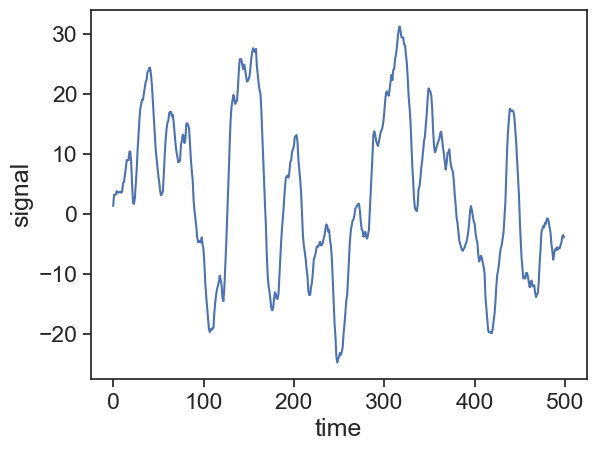

In [23]:
#| code-summary: "plot time series"
fig, ax = plt.subplots()
ax.plot(ar2_values)
ax.set(xlabel="time",
       ylabel="signal");

## ACF

We need to calculate now the autocorrelation function of our series:
$$
\rho_{XX}(\tau) = \frac{E\left[ (X_t - \mu)(X_{t+\tau} - \mu) \right]}{\sigma^2}
$$

In [29]:
#| code-summary: "write a function to compute the acf"
#| code-fold: false
def compute_acf(series):
    N = len(series)
    lags = np.arange(N)
    acf = np.zeros_like(lags)
    series = (series - series.mean()) / series.std()
    for i in lags:
        acf[i] = np.sum(series[i:] * series[:N-i])
    acf = acf / N
    return lags, acf

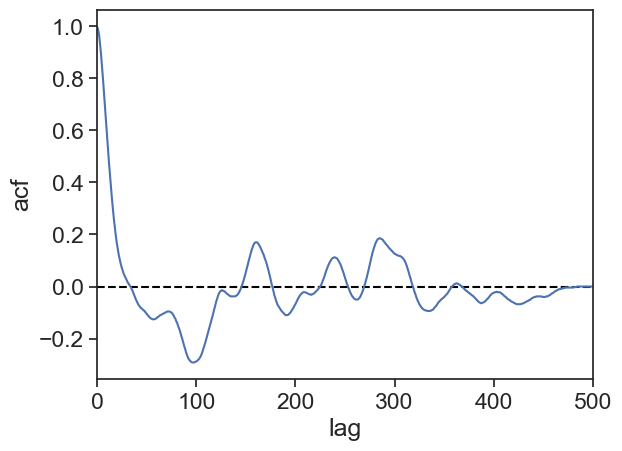

In [42]:
#| code-summary: "plot acf"
fig, ax = plt.subplots()
lags, acf = compute_acf(ar2_values)
ax.plot([0, N], [0]*2, color="black", ls="--")
ax.plot(lags, acf)
ax.set(xlabel="lag",
       ylabel="acf",
       xlim=[0, N]);

Notice that the ACF always starts at 1 for zero lag, and it gets closer to zero as the lag increases.

* **Intuitive interpretation**: Two measurements taken within a short time interval (lag) should be similar, therefore their correlation is expected to be high. As we compare measurements from increasing time intervals, they are less and less similar to one another, therefore their correlation goes down.
* **Mathematical interpretation**: Take a look at the code we wrote above. As the lags grows, the length of both arrays keeps shrinking, but we still divide the result by $N$. The logical conclusion is that when $\tau=N$ the ACF will be exactly zero.

The `statsmodels` package also offers an easy way to plot the ACF, let's compare our calculation with the built-in function:

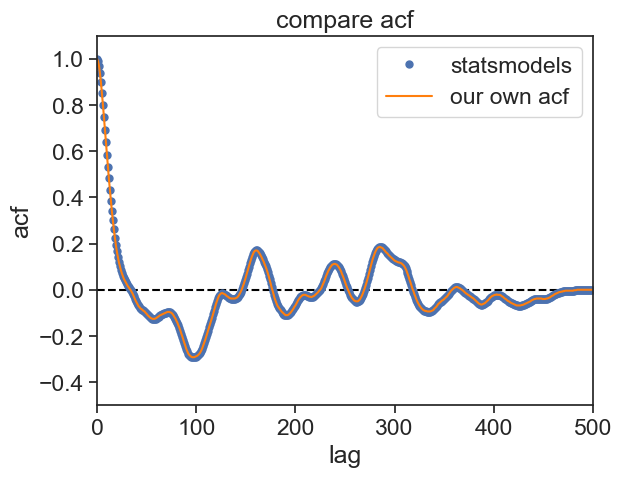

In [41]:
#| code-summary: "plot"
fig, ax = plt.subplots()
ax.plot([0, N], [0]*2, color="black", ls="--")
sm.graphics.tsa.plot_acf(ar2_values, lags= N-1, ax=ax, label="statsmodels", alpha=None, use_vlines=False)
ax.plot(lags, acf, color="tab:orange", label="our own acf")
ax.legend()
ax.set(ylim=[-0.5, 1.1],
       xlim=[0, N],
       title="compare acf",
       xlabel="lag",
       ylabel="acf");

Excellent! From now on we will continue using `statsmodels` functions. We can spice up the ACF graph, by showing an envelope of 95% confidence interval.

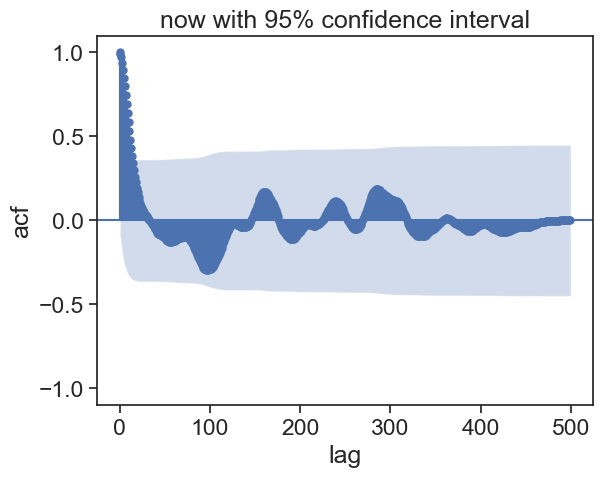

In [27]:
#| code-summary: "plot"
fig, ax = plt.subplots()
sm.graphics.tsa.plot_acf(ar2_values, lags= N-1, ax=ax, alpha=.05)
ax.set(ylim=[-1.1, 1.1],
       title="now confidence interval")
ax.set(ylim=[-1.1, 1.1],
       title="now with 95% confidence interval",
       xlabel="lag",
       ylabel="acf");

If an autocorrelation value at a specific lag falls outside the confidence interval, it suggests that the autocorrelation at that lag is statistically significant. In other words, there is evidence of correlation at that lag.
If an autocorrelation value is within the confidence interval, it suggests that the autocorrelation at that lag is not statistically significant, and any observed correlation might be due to random noise.
The width of the confidence interval is influenced by the significance level. For a 95% confidence interval, it means that you are 95% confident that the true autocorrelation lies within the interval. If you choose a higher confidence level, the interval will become wider, making it harder to reject the null hypothesis of no correlation.

### problem?

There is something a bit troubling about the ACF graph. We can learn from it how fast the correlation between two points in time falls, but this analysis is not too clean. Assume that the present state $x_t$ is only dependent on one time step back, $x_{t-1}$. Because $x_{t-1}$ is dependent on $x_{t-2}$, the result is that we will find that $x_{t}$ is weakly dependent on $x_{t-2}$, although the direct dependence is zero.

The Partial ACF (PACF) solves this problem. It removes the intermediate effects between two points, and returns only the direct influence of one time instant on another one lagged by $\tau$. Let's see how it looks like for the proceess above.

## PACF

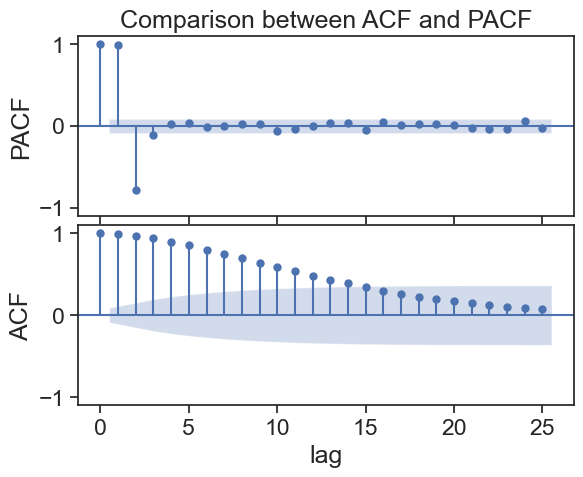

In [37]:
#| code-summary: "plot"
fig, (ax1, ax2) = plt.subplots(2,1)
fig.subplots_adjust(hspace=0.05)
sm.graphics.tsa.plot_pacf(ar2_values, lags=25, ax=ax1, alpha=.05)
ax1.set(ylim=[-1.1, 1.1],
       title="now confidence interval")
ax1.set(ylim=[-1.1, 1.1],
       title="Comparison between ACF and PACF",
       xlabel="lag",
       ylabel="PACF");

sm.graphics.tsa.plot_acf(ar2_values, lags= 25, ax=ax2, alpha=.05, title=None)
ax2.set(ylim=[-1.1, 1.1],
       xlabel="lag",
       ylabel="ACF");

We see three bars significantly far from the confidence interval. The leftmost shows $\text{PACF}(\tau=0)=1$, which is expected, so let's not discuss it. The two next bars are the really important ones, they show the greatest correlation. From then on, the correlation for lags greater than $2$ is not significant. With PACF's help, we can infer that the original AR processes must have been of order $2$.

## discussion

What can we say about the following series?

### sine wave

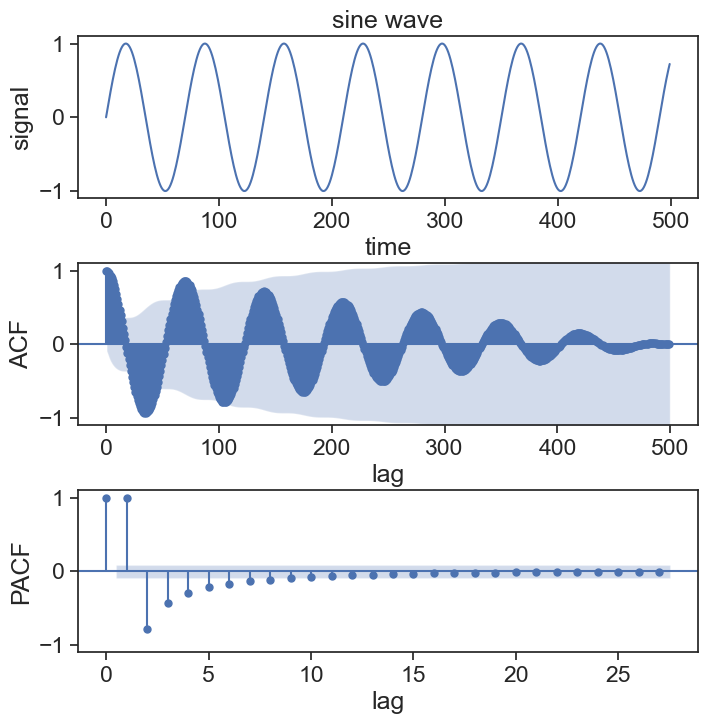

In [57]:
N = 500
time = np.arange(N)
period = 70
omega = 2.0 * np.pi / period
signal = np.sin(omega * time)

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,8))
fig.subplots_adjust(hspace=0.4)

ax1.plot(time, signal)
ax1.set(ylabel="signal",
        title="sine wave",
        xlabel="time")

sm.graphics.tsa.plot_acf(signal, ax=ax2, alpha=.05, title=None, lags=N-1)
ax2.set(ylim=[-1.1, 1.1],
       xlabel="lag",
       ylabel="ACF");

sm.graphics.tsa.plot_pacf(signal, ax=ax3, alpha=.05, title=None)
ax3.set(ylim=[-1.1, 1.1],
       ylabel="PACF",
       xlabel="lag");


### white noise

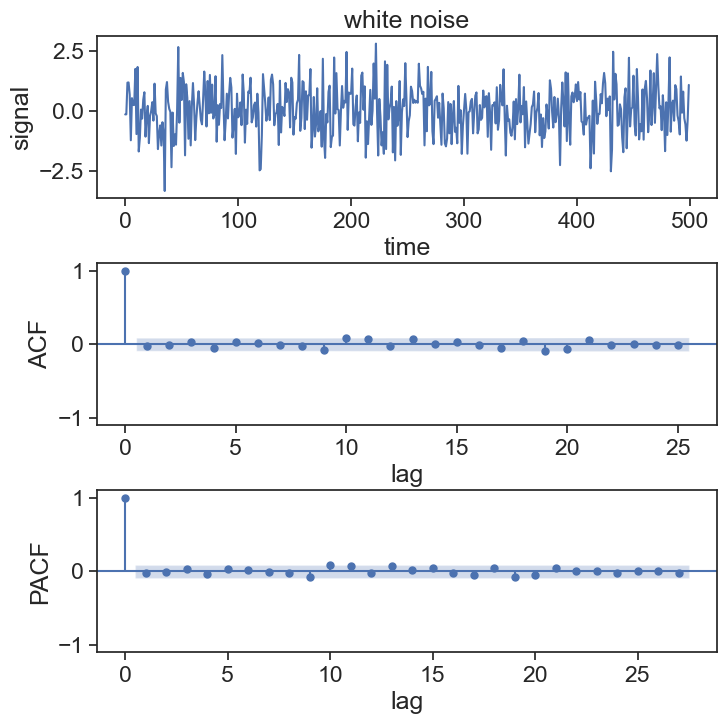

In [62]:
N = 500
time = np.arange(N)
signal = np.random.normal(size=N)

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,8))
fig.subplots_adjust(hspace=0.4)

ax1.plot(time, signal)
ax1.set(ylabel="signal",
        title="white noise",
        xlabel="time")

sm.graphics.tsa.plot_acf(signal, ax=ax2, alpha=.05, title=None, lags=25)
ax2.set(ylim=[-1.1, 1.1],
       xlabel="lag",
       ylabel="ACF");

sm.graphics.tsa.plot_pacf(signal, ax=ax3, alpha=.05, title=None)
ax3.set(ylim=[-1.1, 1.1],
       ylabel="PACF",
       xlabel="lag");


### random walk

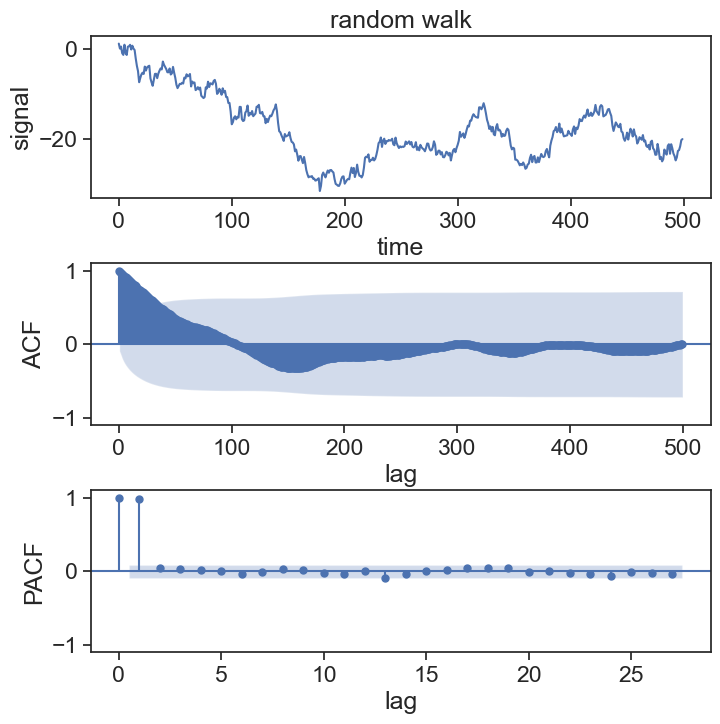

In [65]:
N = 500
time = np.arange(N)
signal = np.cumsum(np.random.normal(size=N))

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,8))
fig.subplots_adjust(hspace=0.4)

ax1.plot(time, signal)
ax1.set(ylabel="signal",
        title="random walk",
        xlabel="time")

sm.graphics.tsa.plot_acf(signal, ax=ax2, alpha=.05, title=None, lags=N-1)
ax2.set(ylim=[-1.1, 1.1],
       xlabel="lag",
       ylabel="ACF");

sm.graphics.tsa.plot_pacf(signal, ax=ax3, alpha=.05, title=None)
ax3.set(ylim=[-1.1, 1.1],
       ylabel="PACF",
       xlabel="lag");
